In [285]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

samples = np.fromfile('fsksignal.dat',dtype=np.float32)
sample_rate = 2048000      # sample rate of sdr
samples_per_bit = 50.4185  # This was computed based on previously seen data.

cumul_widths len = 4574
packet_detect len = 4567
phases len = 4573


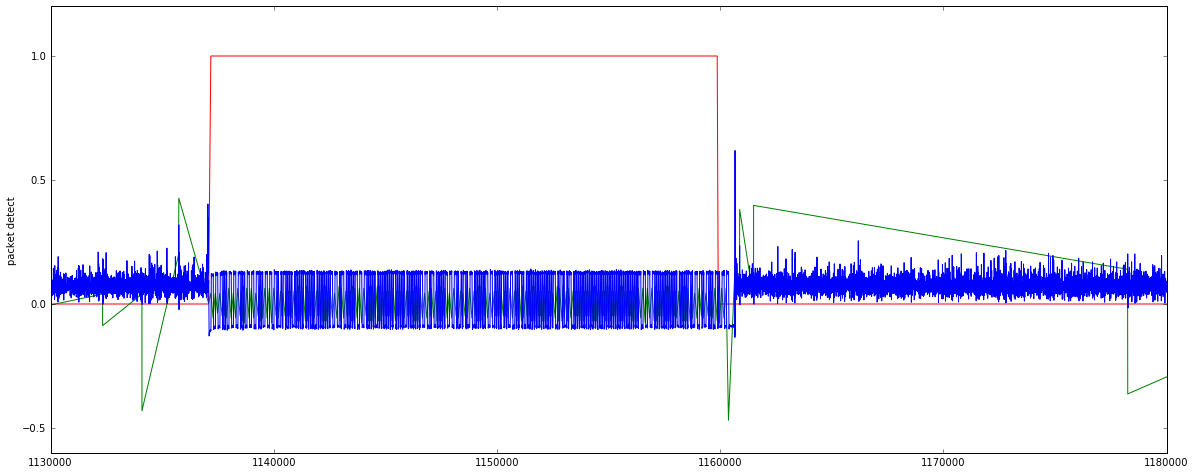

[[ 555754  831693]
 [1137078 1160650]
 [1190810 1203087]]


In [426]:
# Scan through signal looking for packets
# Identify them by transitions happening at the expected bitrate

signs = np.array(samples >= 0, int)
differences = np.diff(signs)
crossings = np.nonzero((differences < 0) | (differences > 0))[0]
cumul_widths = crossings[1:] - crossings[0]
widths = (cumul_widths[1:] - cumul_widths[:-1])
phases = widths % samples_per_bit
# rotate phases on left side to right
phases[phases<(samples_per_bit/2)]+=samples_per_bit

def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

packet_detect = np.absolute(rolling(phases, 4).mean(axis=1) - samples_per_bit)
packet_detect = rolling(packet_detect, 4).max(axis=1) < 0.5

print "cumul_widths len = %s" % cumul_widths.size
print "packet_detect len = %s" % packet_detect.size
print "phases len = %s" % phases.size

plt.figure(figsize=(20,8))
plt.plot(cumul_widths[1:-6],packet_detect, 'r', cumul_widths[:-1], (phases-samples_per_bit)/50, 'g', samples)
plt.ylabel('packet detect')
axes = plt.gca()
axes.set_xlim(1130000,1180000)
plt.show()

startstop = np.nonzero(np.diff(packet_detect))[0].reshape(-1, 2)
startstop[:,1] += 8
startstop[:,0] += 1
packet_offsets = cumul_widths.take(startstop)

# pad out end of detection window
#packet_offsets[:,1] += 1200
#packet_offsets[:,0] -= 600
print packet_offsets

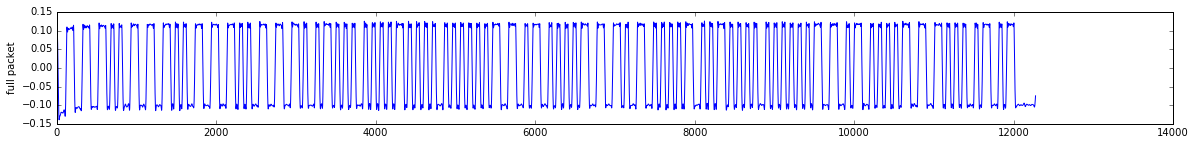

In [428]:
# packet_offsets = [
#     (324848,603305),
#     (936843,1215300),
#     (1548815,1827295),
# ]

# packet_offsets = [
#     (555650, 831650),
#     (1137070, 1160600)
# ]

packet_samples = samples[slice(*packet_offsets[2])]
#packet_samples = samples[1135746:1160650]
#packet_samples = samples[1135746:1160650]
plt.figure(figsize=(20,2))
plt.plot(packet_samples)
plt.ylabel('full packet')
plt.show()


### Zoom in

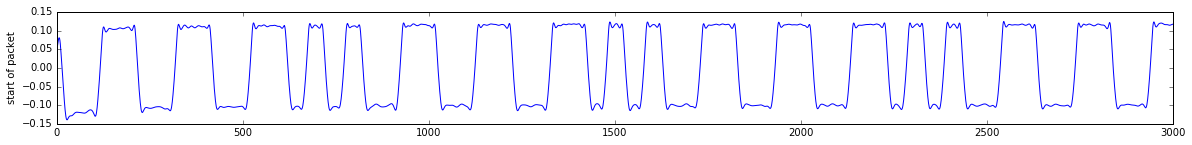

In [429]:
plt.figure(figsize=(20,2))
plt.plot(packet_samples[0:3000])
plt.ylabel('start of packet')
plt.show()


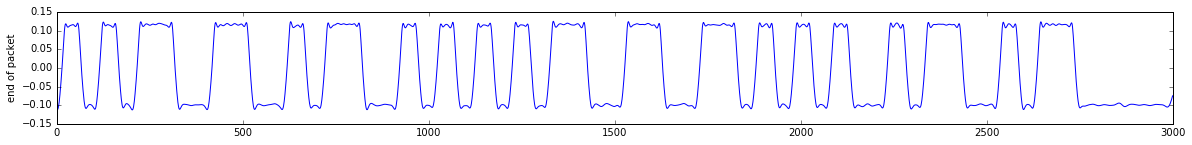

In [430]:
plt.figure(figsize=(20,2))
plt.plot(packet_samples[-3000:])
plt.ylabel('end of packet')
plt.show()

### Detect bitrate

avg samples per bit = 50.4298245614
bit rate = 40611 bps


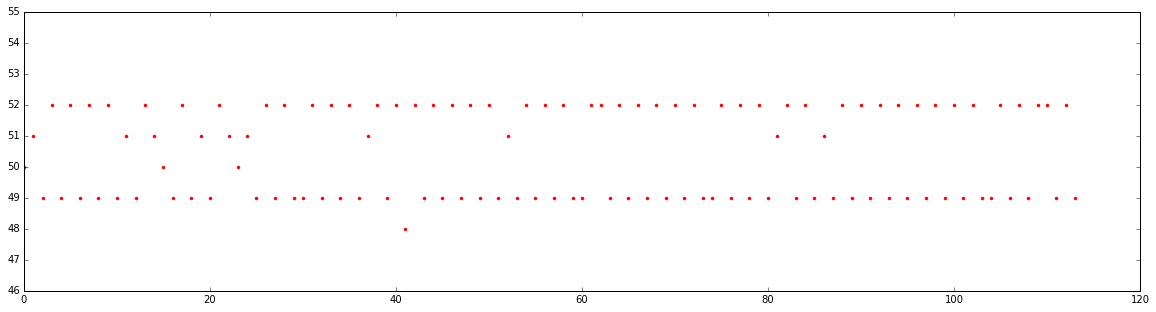

In [431]:
signs = np.array(packet_samples >= 0, int)
differences = np.diff(signs)
#print differences[0:1000]
crossings = np.nonzero((differences < 0) | (differences > 0))[0]
#print crossings
cumulWidths = crossings[1:] - crossings[0]
#print "cumulWidths = %s" % cumulWidths
widths = (cumulWidths[1:] - cumulWidths[:-1])
#plt.hist(widths,bins=30,range=[30,60])
#plt.show()
filtered_widths = widths[(widths > 46) & (widths < 55)]
samples_per_bit = filtered_widths.mean()
print "avg samples per bit = %s" % samples_per_bit
print "bit rate = %s bps" % (sample_rate/samples_per_bit).round().astype(int)

plt.figure(figsize=(20,5))
plt.ylim(46,55)
plt.plot(filtered_widths,'r.')
plt.show()


In [432]:
# Get phase of signal with the modulo of the bitrate of the first 10 crossings
phase_offset = (crossings[:10] % samples_per_bit).mean()
print "Phase offset = %s" % phase_offset

Phase offset = 14.2894736842


### Sample bits from part of packet

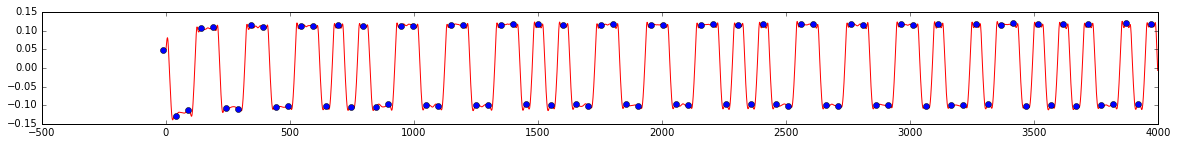

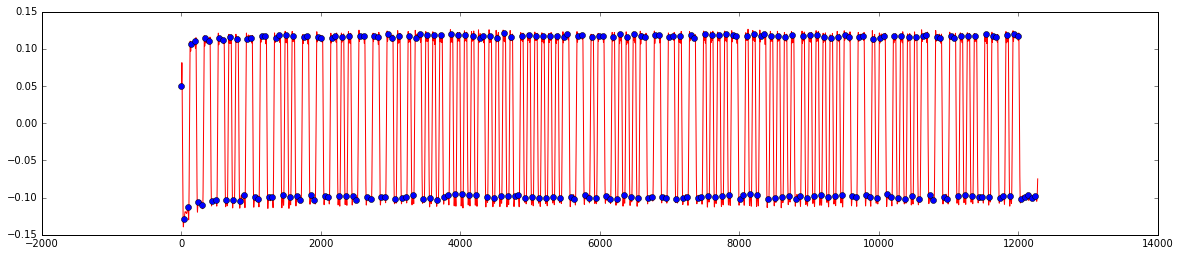

In [433]:
samples_per_bit = 50.41

bit_center_offset = phase_offset - (samples_per_bit / 2.0)

def resample(samples, offset, step):
    centers = np.arange(offset, samples.size, step)
    xp = np.arange(samples.size)
    return (centers, np.interp(centers, xp, samples))

(centers, bits) = resample(packet_samples[:4000], bit_center_offset, samples_per_bit)
plt.figure(figsize=(20,2))
plt.plot(packet_samples[:4000], "r", centers, bits, 'bo')

(centers, bits) = resample(packet_samples, bit_center_offset, samples_per_bit)
plt.figure(figsize=(20,4))
plt.plot(packet_samples, "r", centers, bits, 'bo')


### Get bits for entire packet

In [438]:
(centers, bits) = resample(packet_samples, bit_center_offset, samples_per_bit)
bits = (bits > 0).astype(int)
print "".join(map(str, bits[:80]))

10011001100110101001100110011010100110011001101010011001100110100101101010100101


### Manchester decoding

In [435]:
def manchester_decode(bits, mode='g_e_thomas'):
    decoded = []
    if mode == 'ieee':
        hi_low = 0
        low_hi = 1
    else:
        hi_low = 1
        low_hi = 0
        
    prev = None
    for bit in bits:
        if prev == None:
            prev = bit
            continue
        
        if prev == 0 and bit == 1:
            d = low_hi
            prev = None
        elif prev == 1 and bit == 0:
            d = hi_low
            prev = None
        else:
            d = -1 # Error
            prev = bit
            
        decoded.append(d)
    return np.array(decoded)


In [436]:
print "bits: " + "".join(map(str, bits))
decoded_bits = manchester_decode(bits, 'other')
print "manchester decode: " + "".join(map(str, decoded_bits))
decoded_bits = np.trim_zeros(decoded_bits + 1) - 1 # Trim leading and trailing errors
print "decoded size = %s" % decoded_bits.size
print "manchester decode trimmed: " + "".join(map(str, decoded_bits))


bits: 1001100110011010100110011001101010011001100110101001100110011010010110101010010101010110101010100101010101010110011001011001010101011001100110100110010101010110010101101010101001010101010101100110010110010101010110011001101010100101100101100000
manchester decode: 101010111010101110101011101010110011110000011111000000010100100000101011010000010001111100000001010010000010101111001001-1-1-1
decoded size = 120
manchester decode trimmed: 101010111010101110101011101010110011110000011111000000010100100000101011010000010001111100000001010010000010101111001001


In [439]:
match = 
for i in range(0,decoded_bits.size):
    if 

bytes = np.packbits(decoded_bits[0:])
"".join([format(n, '02x') for n in bytes])

15.0


'abababab3c1f01482b411f01482bc9'